<a href="https://colab.research.google.com/github/Vishnu0920/Reinforcement_Learning/blob/main/CliffWalking_SingleQLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

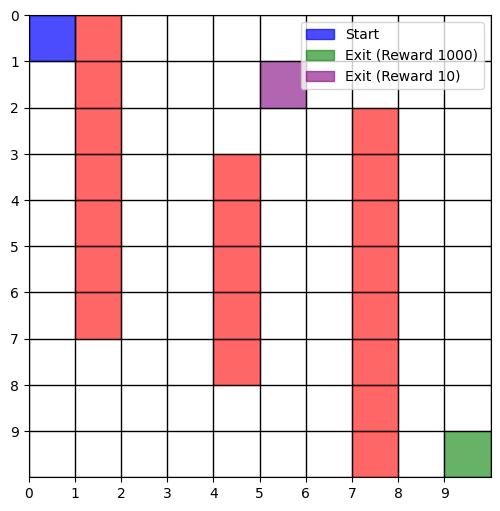

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Grid dimensions
grid_size = (10, 10)

# Cliff positions
cliffs = [(1, y) for y in range(7)] + [(4, y) for y in range(3, 8)] + [(7, y) for y in range(2, 10)]

# Start and exit positions
start = (0, 0)
exit1 = (9, 9)
exit2 = (5, 1)

# Function to plot the grid with (0,0) at bottom left
def plot_grid():
    fig, ax = plt.subplots(figsize=(6, 6))

    # Create grid
    for x in range(grid_size[0] + 1):
        ax.plot([x, x], [0, grid_size[1]], 'k-', lw=1)
    for y in range(grid_size[1] + 1):
        ax.plot([0, grid_size[0]], [y, y], 'k-', lw=1)

    # Mark cliffs
    for cliff in cliffs:
        ax.add_patch(patches.Rectangle((cliff[0], cliff[1]), 1, 1, color="red", alpha=0.6))

    # Mark start and exits
    ax.add_patch(patches.Rectangle(start, 1, 1, color="blue", alpha=0.7, label="Start"))
    ax.add_patch(patches.Rectangle(exit1, 1, 1, color="green", alpha=0.6, label="Exit (Reward 1000)"))
    ax.add_patch(patches.Rectangle(exit2, 1, 1, color="purple", alpha=0.6, label="Exit (Reward 10)"))

    # Set limits, labels, and legend
    ax.set_xlim(0, grid_size[0])
    ax.set_ylim(0, grid_size[1])
    ax.set_xticks(np.arange(0, grid_size[0], 1))
    ax.set_yticks(np.arange(0, grid_size[1], 1))
    ax.set_aspect('equal')
    ax.legend(loc="upper right")
    ax.grid(False)

    # Flip y-axis to make (0,0) at the bottom left
    plt.gca().invert_yaxis()

    plt.show()

# Display the grid world with (0,0) at bottom left
plot_grid()


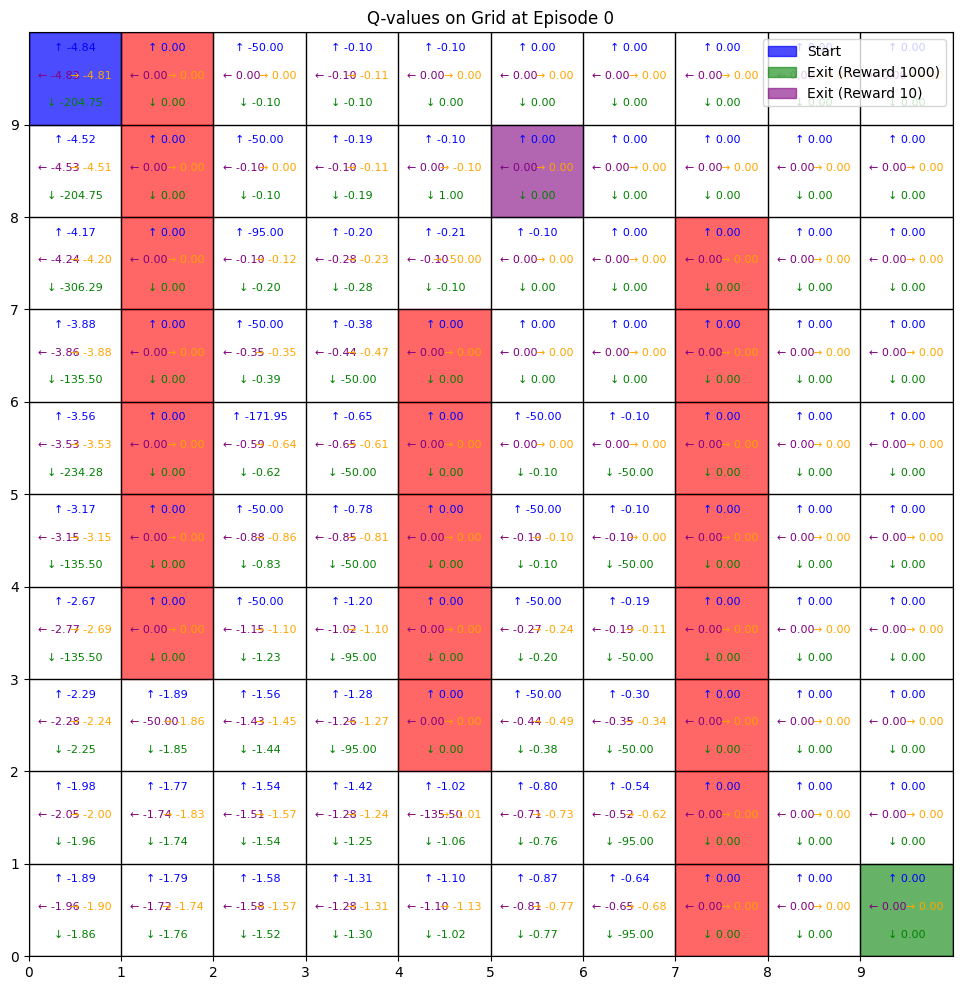

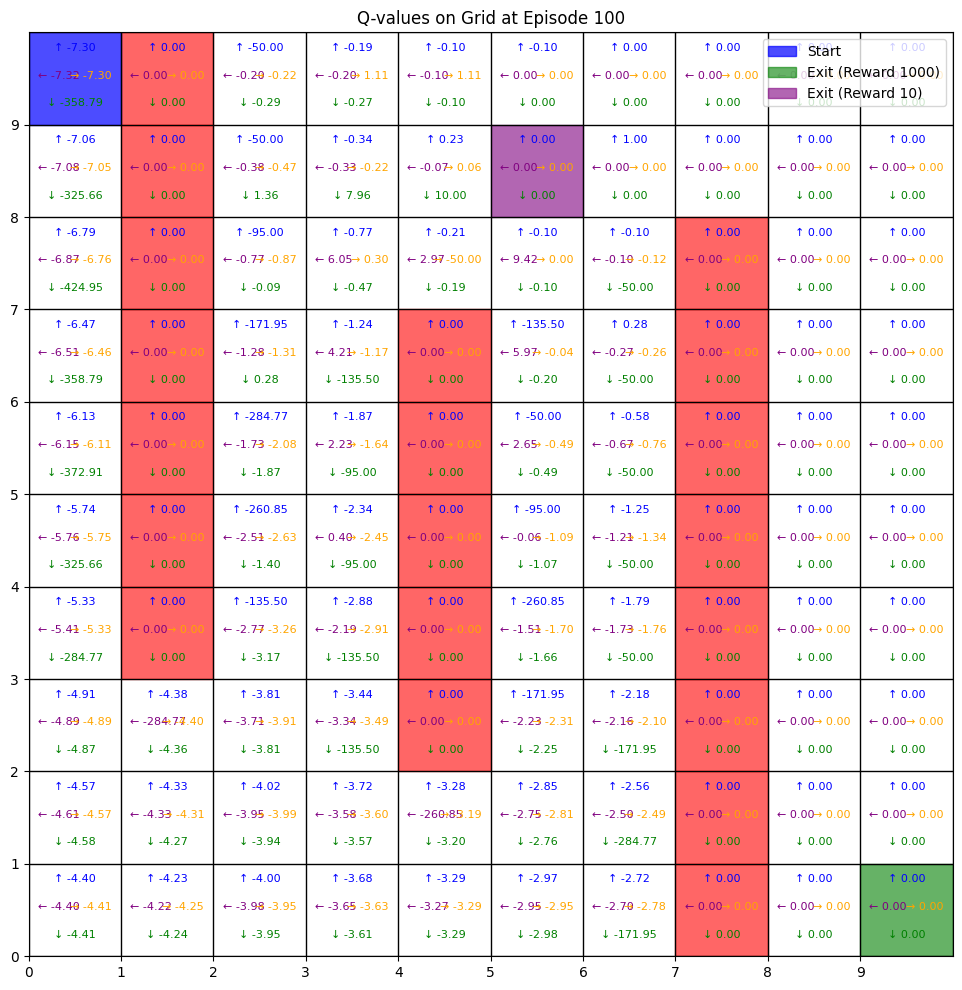

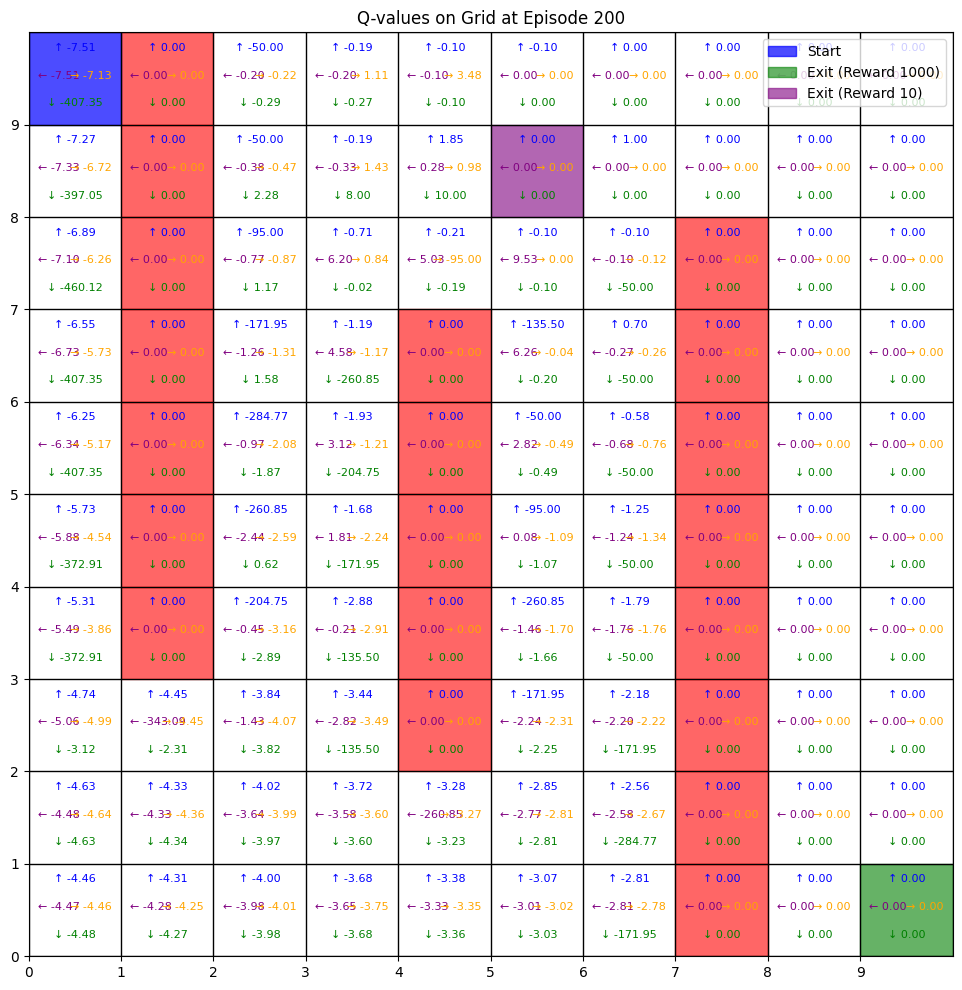

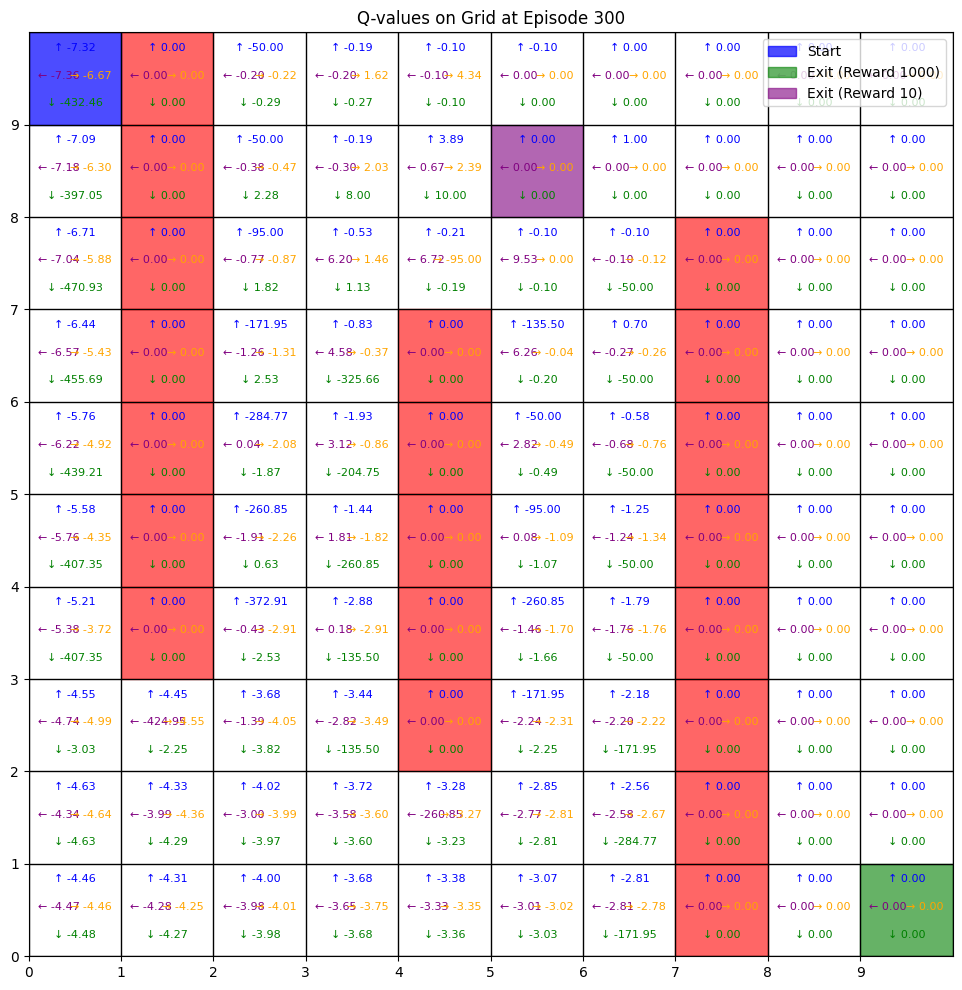

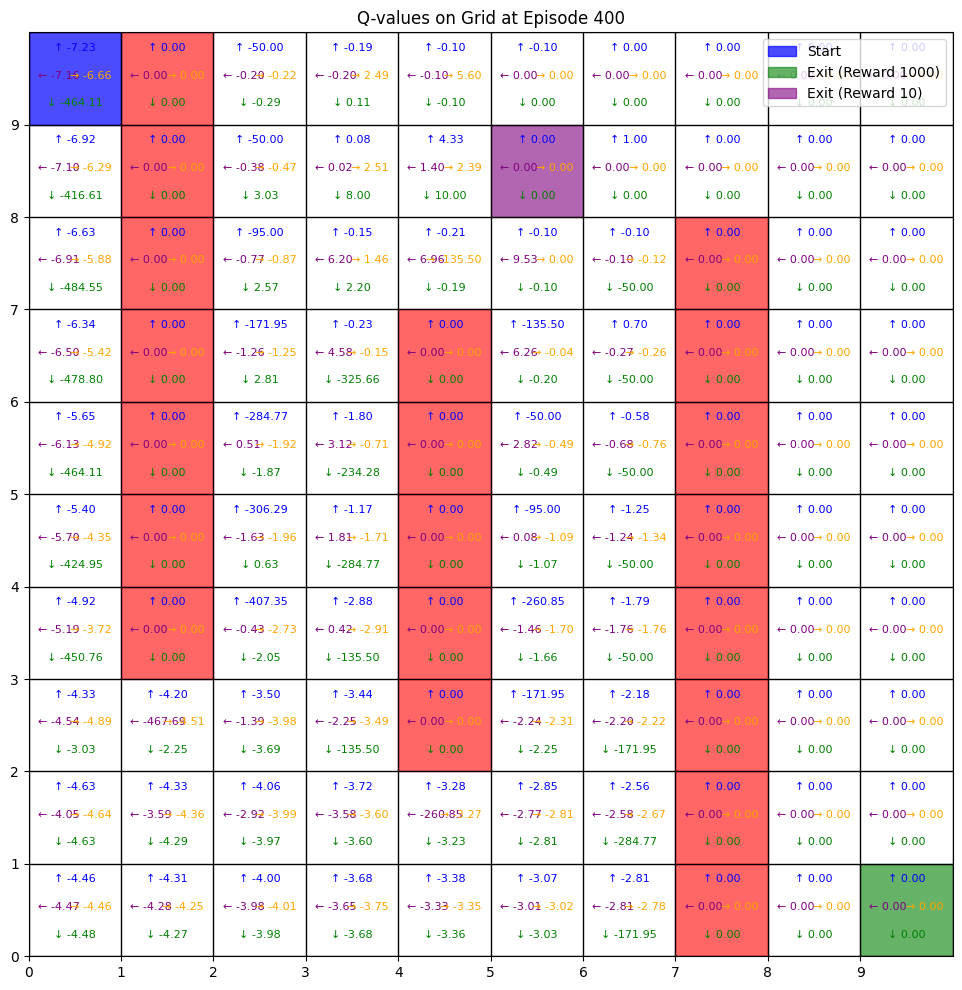

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Parameters
grid_size = (10, 10)
alpha = 0.1   # Learning rate
gamma = 0.9   # Discount factor
epsilon = 0.1 # Exploration rate
episodes = 500 # Number of episodes to train

# Cliff positions, start, and exit points
cliffs = [(1, y) for y in range(7)] + [(4, y) for y in range(3, 8)] + [(7, y) for y in range(2, 10)]
start = (0, 0)
exit1 = (9, 9)
exit2 = (5, 1)

# Initialize Q-table with zeros
Q = np.zeros((grid_size[0], grid_size[1], 4))  # 4 possible actions: up, down, left, right

# Possible actions and movements
actions = {
    0: (-1, 0),  # Up
    1: (1, 0),   # Down
    2: (0, -1),  # Left
    3: (0, 1)    # Right
}

# Reward function based on the given setup
def get_reward(state):
    if state == exit1:
        return 1000
    elif state == exit2:
        return 10
    elif state in cliffs:
        return -500  # Cliff penalty
    elif state[0] < 0 or state[0] >= grid_size[0] or state[1] < 0 or state[1] >= grid_size[1]:
        return -500  # Out of bounds (same as cliff penalty for simplicity)
    else:
        return -1  # Regular movement cost

# Function to plot the grid with Q-values
def plot_grid_with_q_values(Q, title="Q-values on Grid"):
    fig, ax = plt.subplots(figsize=(12, 12))

    # Create grid and mark cliffs
    for x in range(grid_size[0] + 1):
        ax.plot([x, x], [0, grid_size[1]], 'k-', lw=1)
    for y in range(grid_size[1] + 1):
        ax.plot([0, grid_size[0]], [y, y], 'k-', lw=1)

    # Mark cliffs
    for cliff in cliffs:
        ax.add_patch(patches.Rectangle((cliff[0], grid_size[1] - cliff[1] - 1), 1, 1, color="red", alpha=0.6))

    # Mark start and exits
    ax.add_patch(patches.Rectangle((start[0], grid_size[1] - start[1] - 1), 1, 1, color="blue", alpha=0.7, label="Start"))
    ax.add_patch(patches.Rectangle((exit1[0], grid_size[1] - exit1[1] - 1), 1, 1, color="green", alpha=0.6, label="Exit (Reward 1000)"))
    ax.add_patch(patches.Rectangle((exit2[0], grid_size[1] - exit2[1] - 1), 1, 1, color="purple", alpha=0.6, label="Exit (Reward 10)"))

    # Display Q-values within each cell
    for i in range(grid_size[0]):
        for j in range(grid_size[1]):
            # Flip y-axis for plotting
            cell_y = grid_size[1] - j - 1
            # Display each Q-value inside the cell for each action
            q_up = f"↑ {Q[i, j, 0]:.2f}"
            q_down = f"↓ {Q[i, j, 1]:.2f}"
            q_left = f"← {Q[i, j, 2]:.2f}"
            q_right = f"→ {Q[i, j, 3]:.2f}"
            ax.text(i + 0.5, cell_y + 0.8, q_up, fontsize=8, ha="center", color="blue")
            ax.text(i + 0.5, cell_y + 0.2, q_down, fontsize=8, ha="center", color="green")
            ax.text(i + 0.1, cell_y + 0.5, q_left, fontsize=8, ha="left", color="purple")
            ax.text(i + 0.9, cell_y + 0.5, q_right, fontsize=8, ha="right", color="orange")

    ax.set_xlim(0, grid_size[0])
    ax.set_ylim(0, grid_size[1])
    ax.set_xticks(np.arange(0, grid_size[0], 1))
    ax.set_yticks(np.arange(0, grid_size[1], 1))
    ax.set_aspect('equal')
    ax.legend(loc="upper right")
    ax.grid(False)
    plt.title(title)
    plt.show()

# Q-learning algorithm with cliff penalty and reset
def q_learning():
    for episode in range(episodes):
        state = start
        done = False

        while not done:
            # Choose action (epsilon-greedy policy)
            if random.uniform(0, 1) < epsilon:
                action = random.choice(list(actions.keys()))  # Explore
            else:
                action = np.argmax(Q[state[0], state[1]])     # Exploit

            # Determine the next state based on the action
            next_state = (state[0] + actions[action][0], state[1] + actions[action][1])

            # Check if next state is out of bounds; if so, reset to current state
            if next_state[0] < 0 or next_state[0] >= grid_size[0] or next_state[1] < 0 or next_state[1] >= grid_size[1]:
                next_state = state

            # Get the reward for the next state
            reward = get_reward(next_state)

            # Q-learning update rule
            best_next_action = np.argmax(Q[next_state[0], next_state[1]])
            Q[state[0], state[1], action] += alpha * (reward + gamma * Q[next_state[0], next_state[1], best_next_action] - Q[state[0], state[1], action])

            # If agent encounters a cliff, reset to start
            if next_state in cliffs:
                state = start
            else:
                state = next_state

            # Check if the agent has reached an exit
            if state == exit1 or state == exit2:
                done = True

        # Plot Q-values every 100 episodes to observe progression
        if episode % 100 == 0:
            plot_grid_with_q_values(Q, title=f"Q-values on Grid at Episode {episode}")

# Run Q-learning
q_learning()


Efficient Path: [(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (1, 7), (2, 7), (2, 6), (2, 5), (2, 4), (3, 4), (3, 3), (3, 2), (3, 1), (4, 1), (5, 1)]


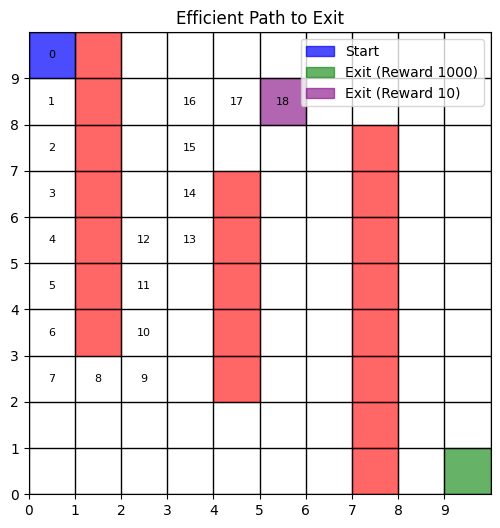

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Parameters
grid_size = (10, 10)
alpha = 0.1   # Learning rate
gamma = 0.9   # Discount factor
epsilon = 0.1 # Exploration rate
episodes = 500 # Number of episodes to train

# Cliff positions, start, and exit points
cliffs = [(1, y) for y in range(7)] + [(4, y) for y in range(3, 8)] + [(7, y) for y in range(2, 10)]
start = (0, 0)
exit1 = (9, 9)
exit2 = (5, 1)

# Initialize Q-table with zeros
Q = np.zeros((grid_size[0], grid_size[1], 4))  # 4 possible actions: up, down, left, right

# Possible actions and movements
actions = {
    0: (-1, 0),  # Up
    1: (1, 0),   # Down
    2: (0, -1),  # Left
    3: (0, 1)    # Right
}

# Reward function based on the given setup
def get_reward(state):
    if state == exit1:
        return 1000
    elif state == exit2:
        return 10
    elif state in cliffs:
        return -500  # Cliff penalty
    elif state[0] < 0 or state[0] >= grid_size[0] or state[1] < 0 or state[1] >= grid_size[1]:
        return -500  # Out of bounds
    else:
        return -1  # Regular movement cost

# Q-learning algorithm with cliff penalty and reset
def q_learning():
    for episode in range(episodes):
        state = start
        done = False

        while not done:
            # Choose action (epsilon-greedy policy)
            if np.random.uniform(0, 1) < epsilon:
                action = np.random.choice(list(actions.keys()))  # Explore
            else:
                action = np.argmax(Q[state[0], state[1]])        # Exploit

            # Determine the next state based on the action
            next_state = (state[0] + actions[action][0], state[1] + actions[action][1])

            # Check if next state is out of bounds; if so, reset to current state
            if next_state[0] < 0 or next_state[0] >= grid_size[0] or next_state[1] < 0 or next_state[1] >= grid_size[1]:
                next_state = state

            # Get the reward for the next state
            reward = get_reward(next_state)

            # Q-learning update rule
            best_next_action = np.argmax(Q[next_state[0], next_state[1]])
            Q[state[0], state[1], action] += alpha * (reward + gamma * Q[next_state[0], next_state[1], best_next_action] - Q[state[0], state[1], action])

            # If agent encounters a cliff, reset to start
            if next_state in cliffs:
                state = start
            else:
                state = next_state

            # Check if the agent has reached an exit
            if state == exit1 or state == exit2:
                done = True

# Function to find and display the efficient path based on Q-values
def find_efficient_path():
    path = [start]
    state = start

    while state != exit1 and state != exit2:
        action = np.argmax(Q[state[0], state[1]])  # Choose the action with the highest Q-value
        next_state = (state[0] + actions[action][0], state[1] + actions[action][1])

        # If next state is out of bounds or cliff, reset to start
        if next_state[0] < 0 or next_state[0] >= grid_size[0] or next_state[1] < 0 or next_state[1] >= grid_size[1] or next_state in cliffs:
            path.append("Cliff encountered, reset to start")
            state = start
        else:
            path.append(next_state)
            state = next_state

        # Avoid looping indefinitely
        if len(path) > 100:
            break

    return path

# Function to plot the grid with efficient path highlighted
def plot_grid_with_path(path):
    fig, ax = plt.subplots(figsize=(6, 6))

    # Create grid and mark cliffs
    for x in range(grid_size[0] + 1):
        ax.plot([x, x], [0, grid_size[1]], 'k-', lw=1)
    for y in range(grid_size[1] + 1):
        ax.plot([0, grid_size[0]], [y, y], 'k-', lw=1)

    # Mark cliffs
    for cliff in cliffs:
        ax.add_patch(patches.Rectangle((cliff[0], grid_size[1] - cliff[1] - 1), 1, 1, color="red", alpha=0.6))

    # Mark start and exits
    ax.add_patch(patches.Rectangle((start[0], grid_size[1] - start[1] - 1), 1, 1, color="blue", alpha=0.7, label="Start"))
    ax.add_patch(patches.Rectangle((exit1[0], grid_size[1] - exit1[1] - 1), 1, 1, color="green", alpha=0.6, label="Exit (Reward 1000)"))
    ax.add_patch(patches.Rectangle((exit2[0], grid_size[1] - exit2[1] - 1), 1, 1, color="purple", alpha=0.6, label="Exit (Reward 10)"))

    # Plot the path
    for idx, state in enumerate(path):
        if state == "Cliff encountered, reset to start":
            continue  # Skip cliffs in visualization
        ax.text(state[0] + 0.5, grid_size[1] - state[1] - 0.5, str(idx), ha='center', va='center', color="black", fontsize=8)

    ax.set_xlim(0, grid_size[0])
    ax.set_ylim(0, grid_size[1])
    ax.set_xticks(np.arange(0, grid_size[0], 1))
    ax.set_yticks(np.arange(0, grid_size[1], 1))
    ax.set_aspect('equal')
    ax.legend(loc="upper right")
    ax.grid(False)

    plt.title("Efficient Path to Exit")
    plt.show()

# Run Q-learning to train Q-values
q_learning()

# Find and plot the efficient path
path = find_efficient_path()
print("Efficient Path:", path)
plot_grid_with_path(path)
